
<img src="../images/ExoPhotlogo.png"   
     width=150px
     alt="ExoPhot icon"
     style="float: left; margin-right: 10px;" /> 

# ExoPhot Spectral Absorption Rate interface
This notebook is intended for the selection of stars, exoplanetary atmospheres and photosystems and plotting their spectral absorption rate. It also tabulates the total absorption rate for the selected systems.



In [1]:
#%matplotlib notebook

# Import required packages
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
import numpy as np
import pandas as pd


import sys
sys.path.append("..")
from codes import spectral_overlap_functions as sof # .py file with functions needed to quantify spectral overlap


# Retrieve Total Absorption Rates (TAR) stored dataframe
%store -r tar_table_df

## Star selection
Select the spectral type of the host star:

In [2]:
stellar_type_list = ['a5v', 'g2v','m8v']

selected_stellar_type = widgets.Dropdown(
                options=stellar_type_list,
                value='g2v',
                description='Stellar type',
                disabled=False)


def stellar_type_handler(change):
     change.new  
    
selected_stellar_type.observe(stellar_type_handler, names='value')

display(selected_stellar_type)



Dropdown(description='Stellar type', index=1, options=('a5v', 'g2v', 'm8v'), value='g2v')

## Exoplanet selection

Select the inner, middle or outer part of the exoplanet habitable zone and the type of atmosphere (os1: Earth-like; os2: highly oxidizing, os3; weakly oxidizing; os4: reducing):


In [3]:
hz_list = ['hzi', 'hzm','hzo']
atmosphere_list = ['os1','os2','os3','os4']

selected_hz = widgets.Dropdown(
                options=hz_list,
                value='hzm',
                description='HZ',
                disabled=False)

selected_atmosphere = widgets.Dropdown(
                options=atmosphere_list,
                value='os1',
                description='Atmosphere type',
                disabled=False)

def hz_handler(change):
    change.new  
def atmosphere_handler(change):
    change.new  
    
selected_hz.observe(hz_handler, names='value')
selected_atmosphere.observe(atmosphere_handler, names='value')

display(selected_hz)
display(selected_atmosphere)



Dropdown(description='HZ', index=1, options=('hzi', 'hzm', 'hzo'), value='hzm')

Dropdown(description='Atmosphere type', options=('os1', 'os2', 'os3', 'os4'), value='os1')

## Pigment selection
Select one of the available pigments:

In [4]:
pigment_list = ['BChlA','BChlB','ChlA','ChlB','Phot0-Zn']

selected_pigment = widgets.Dropdown(
                options=pigment_list,
                value='ChlA',
                description='Pigment',
                disabled=False)

def pigment_handler(change):
    change.new  
    
selected_pigment.observe(pigment_handler, names='value')

display(selected_pigment)



Dropdown(description='Pigment', index=2, options=('BChlA', 'BChlB', 'ChlA', 'ChlB', 'Phot0-Zn'), value='ChlA')

# Table of results

In [5]:
current_system = tar_table_df.loc[(tar_table_df["Star"]==selected_stellar_type.value) & 
                      (tar_table_df["Atmosphere"]==selected_atmosphere.value) & 
                      (tar_table_df["HZ"]==selected_hz.value) & 
                      (tar_table_df["Pigment"]==selected_pigment.value)]

#Set precision of pandas to 2 
pd.set_option('precision', 2)

current_system[["Star","HZ","Atmosphere","Pigment","gamma_t","gamma_B","gamma_Q","ppfd","S"]].style


,Star,HZ,Atmosphere,Pigment,gamma_t,gamma_B,gamma_Q,ppfd,S
43,g2v,hzm,os1,ChlA,9.20,4.65,4.55,2115.69,1370.04


In [6]:
#Reset precision for the rest of the processes
pd.reset_option('precision')

# Spectral Absorption Rate plotting (including stellar flux, atmosphere transmittance and pigment absorption cross section)
With the selected star, HZ, atmosphere type and pigment, the corresponding SOF (spectral overlap file) is retrieved 
from the `ExoPhot/output/SOF` folder. These parameters are plotted vs. wavelength. The SOF contains, in columns:
- Col 1: Wavelength (wl in Angstrom) 
- Col 2: Spectral Flux Density (F_l in J cm-2 s-1 A-1) 
- Col 3: Atmosphere transmitance (T, no units) 
- Col 4: Pigment absorption cross section (sigma_abs in cm2) 
- Col 5: Spectral Absorption Rate (Gamma_lambda in A-1 s-1)

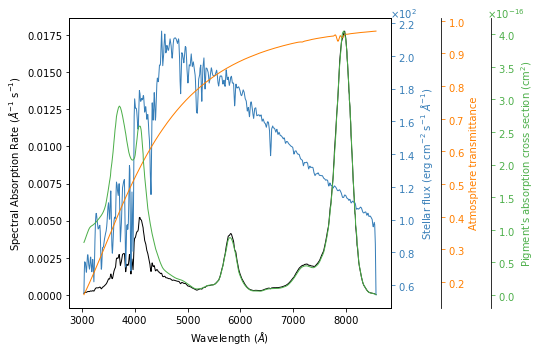

In [8]:
# specify SOF names
SOF_file='../output/SOF/'+'atm_'+selected_stellar_type.value+'_'+selected_hz.value+'_'+selected_atmosphere.value+'_'+selected_pigment.value+'.txt'

# read files to retrieve spectra
data = np.loadtxt(SOF_file,usecols=(0,1,2,3,4)) 
data = np.transpose(data)

# reorder parameters for plotting purposeses
y_sorted = [4,1,2,3]
y_values = data[y_sorted]

#Flux in Joules transformed to ergs 
# 1J = 10E7 ergs
y_values[1]=y_values[1]*1e7


#colors = ['black', 'red', 'blue', 'green']
colors = ['black', '#377eb8', '#ff7f00','#4daf4a']
CB_color_cycle = ['#377eb8', '#ff7f00','#4daf4a', '#e41a1c',
                   '#a65628', '#984ea3', #'#f781bf',
                  '#999999',  '#dede00']

labels = ['Spectral Absorption Rate ($\AA^{-1}$ s$^{-1}$)', 
          'Stellar flux (erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$)', 
          'Atmosphere transmittance', 
          'Pigment\'s absorption cross section (cm$^{2}$)']

# define other paramters (e.g. linestyle etc.) in lists

fig, ax_orig = plt.subplots(figsize=(8, 5))
for i, (arr, color, label) in enumerate(zip(y_values, colors, labels)):
    if i == 0:
        ax = ax_orig
        ax.set_ylabel(label, color=color)
        ax.plot(data[0],y_values[0], color=color, linestyle='-',linewidth=1, alpha=1)
    else:
        ax = ax_orig.twinx()
        ax.spines['right'].set_position(('outward', 50 * (i - 1)))
        ax.plot(data[0],arr, color=color, linestyle='-',linewidth=1, alpha=1)
        ax.set_ylabel(label, color=color)
        
        yfmt = tic.ScalarFormatter(useMathText=True)
        yfmt.set_powerlimits((-6, -5))
        ax.yaxis.set_major_formatter(yfmt)
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        ax.get_yaxis().get_offset_text().set_visible(False)
        ax_max = max(ax.get_yticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis!=0:
            ax.annotate(r'$\times$10$^{%i}$'%(exponent_axis),
             xy=((0.999+(0.15 * (i - 1))), .999), color=color, xycoords='axes fraction')

        #ax.get_yaxis().get_offset_text().set_position(0.5, 0)
    ax.set_xlabel('Wavelength ($\AA$)')    

    ax.tick_params(axis='y', colors=color)
fig.tight_layout()
plt.savefig('../output/figures/visual_spectral_overlap_plot_PNAS_v4.pdf', dpi=150)
plt.show()

